In [2]:
from data_preparation import DataPreparator
from apply_clustering import ClusteringApplier
import config

In [3]:
import matplotlib.pyplot as plt

In [4]:
import pandas as pd

In [5]:
DataPreparator.prepare_data()

In [8]:
save_folder: str = f"{config.OUTPUT_FOLDER_BASE}base_data/"
my_folder = f"{save_folder}{config.DATASET_NAME}_explainable_scaling_factors.xlsx"

pd.read_excel(my_folder)

,feature,scaling
0,Age,3
1,Sex,1
2,Zoo,20
3,Stable,1
4,Genus_ID,730
5,Family_ID,981
6,Order_ID,2
7,SH,175
8,Weight,2300
9,Habitat,3


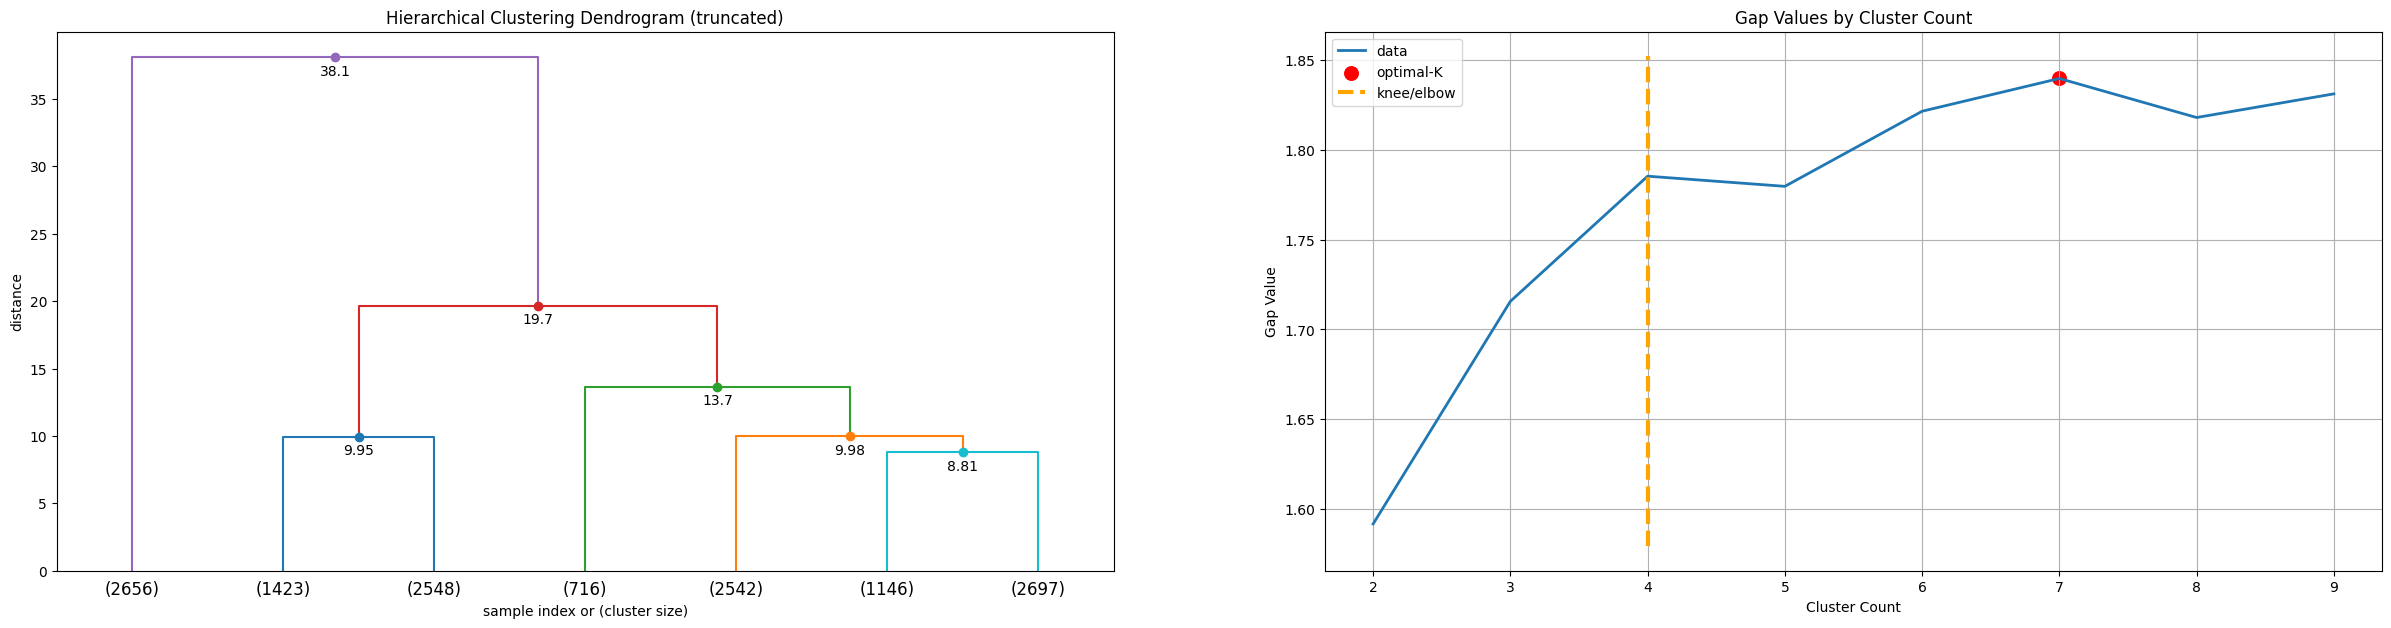

: 

In [ ]:
# Experiments for:
ClusteringApplier.draw_gap_statistic_plot()

In [3]:
import pandas as pd
import numpy as np

from sklearn.cluster import AgglomerativeClustering

In [4]:
df: pd.DataFrame = ClusteringApplier._read_observable_data()

In [5]:
from gapstatistics.gapstatistics import GapStatistics
from sklearn.datasets import make_blobs

if False:

    centers = [[0,0], [0,6], [3,2], [5,0]]
    _X = make_blobs(n_samples=200, centers=centers, n_features=2, cluster_std=1)
    n_iterations = 30

    gs = GapStatistics(distance_metric='minkowski', return_params=True)

    optimum, params = gs.fit_predict(K=15, X=X)#[0])

    gs.plot()
    optimum

In [6]:
from sklearn.neighbors import NearestCentroid

def agglomerative_clustering_function(X, k, **kwargs):
    """ 
    These user defined functions *must* take the X and a k 
    and can take an arbitrary number of other kwargs, which can
    be pass with `clusterer_kwargs` when initializing OptimalK
    """
    
    # Here you can do whatever clustering algorithm you heart desires,
    # but we'll do a simple wrap of the MeanShift model in sklearn.
    
    model = AgglomerativeClustering(n_clusters=k, linkage='ward', compute_distances=False)
    y = model.fit_predict(X)
    nearest_centroid = NearestCentroid()
    nearest_centroid.fit(X, y)

    cluster_centers_ = nearest_centroid.centroids_
    
    # Return the location of each cluster center,
    # and the labels for each point.
    return cluster_centers_, y


In [7]:
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt
from typing import Callable

def fancy_dendrogram(*args, **kwargs):
    '''
    From: https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
    '''
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

def get_linkage_matrix(model:Callable):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    return linkage_matrix

def plot_dendrogram(model, dendogram_function: Callable=dendrogram, **kwargs):

    linkage_matrix = get_linkage_matrix(model)
    dendogram_function(linkage_matrix, **kwargs)

In [8]:
from typing import Callable, Literal, Any, Union, Iterable
from gap_statistic import OptimalK
from sklearn.cluster import AgglomerativeClustering


class OptimalK_Wrapper(OptimalK):
    def __init__(self,
                 clusterer: Callable = AgglomerativeClustering,
                 clusterer_kwargs: dict = {
                     'linkage': 'ward'
                     }
        ):
        super().__init__(
            clusterer=clusterer,
            clusterer_kwargs=clusterer_kwargs
        )

    def find_optimal_K(
        self,
        X: Union[pd.DataFrame, np.ndarray],
        n_refs: int = 3,
        cluster_array: Iterable[int] = ()
        ):

        """
        Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
        http://www.web.stanford.edu/~hastie/Papers/gap.pdf
        :param X - pandas dataframe or numpy array of data points of shape (n_samples, n_features)
        :param n_refs - int: Number of random reference data sets used as inertia reference to actual data.
        :param cluster_array - 1d iterable of integers; each representing n_clusters to try on the data.
        """

        # Convert the 1d array of n_clusters to try into an array
        # Raise error if values are less than 1 or larger than the unique sample in the set.
        cluster_array = np.array([x for x in cluster_array]).astype(int)
        if np.where(cluster_array < 1)[0].shape[0]:
            raise ValueError(
                "cluster_array contains values less than 1: {}".format(
                    cluster_array[np.where(cluster_array < 1)[0]]
                )
            )
        if cluster_array.shape[0] > X.shape[0]:
            raise ValueError(
                "The number of suggested clusters to try ({}) is larger than samples in dataset. ({})".format(
                    cluster_array.shape[0], X.shape[0]
                )
            )
        if not cluster_array.shape[0]:
            raise ValueError("The supplied cluster_array has no values.")

        # Array of resulting gaps.
        gap_df = pd.DataFrame({"n_clusters": [], "gap_value": []})

        # Define the compute engine; all methods take identical args and are generators.
        if self.parallel_backend == "joblib":
            engine = self._process_with_joblib
        elif self.parallel_backend == "multiprocessing":
            engine = self._process_with_multiprocessing
        elif self.parallel_backend == "rust":
            engine = self._process_with_rust
        else:
            engine = self._process_non_parallel

        # Calculate the gaps for each cluster count.
        my_data = []
        for gap_calc_result in engine(X, n_refs, cluster_array):

            my_data.append({
                    "n_clusters": gap_calc_result.n_clusters,
                    "gap_value": gap_calc_result.gap_value,
                    "ref_dispersion_std": gap_calc_result.ref_dispersion_std,
                    "sdk": gap_calc_result.sdk,
                    "sk": gap_calc_result.sk,
                    "gap*": gap_calc_result.gap_star,
                    "sk*": gap_calc_result.sk_star,
            })

            # Assign this loop's gap statistic to gaps
            gap_df = pd.DataFrame(my_data)
            
            gap_df["gap_k+1"] = gap_df["gap_value"].shift(-1)
            gap_df["gap*_k+1"] = gap_df["gap*"].shift(-1)
            gap_df["sk+1"] = gap_df["sk"].shift(-1)
            gap_df["sk*+1"] = gap_df["sk*"].shift(-1)
            gap_df["diff"] = gap_df["gap_value"] - gap_df["gap_k+1"] + gap_df["sk+1"]
            gap_df["diff*"] = gap_df["gap*"] - gap_df["gap*_k+1"] + gap_df["sk*+1"]

        # drop auxilariy columns
        gap_df.drop(
            labels=["sdk", "gap_k+1", "gap*_k+1", "sk+1", "sk*+1"],
            axis=1,
            inplace=True,
            errors="ignore",
        )

        self.gap_df = gap_df.sort_values(by="n_clusters", ascending=True).reset_index(
            drop=True
        )
        self.n_clusters = int(
            self.gap_df.loc[np.argmax(self.gap_df.gap_value.values)].n_clusters
        )
    
        return self.gap_df #self.n_clusters

In [9]:
df.head()

,num_lhd,num_lying,perc_lhd,perc_lying
0,1.000571,0.250403,0.014091,0.056742
1,1.002405,0.398789,0.017853,0.054594
2,0.999462,0.172592,0.007344,0.030000
3,0.999443,0.426562,0.008964,0.054072
4,0.999517,0.415520,0.010314,0.067722


In [10]:
X = df.to_numpy()

In [11]:
if True:
    X_sc = (X - X.min(axis = 0)) / (X.max(axis = 0) - X.min(axis = 0))
    df = pd.DataFrame(data=X_sc, index = df.index, columns = df.columns)

In [12]:
def minmax(x):
    return (x - x.min())/(x.max() - x.min())

In [13]:
# Preprocessing: config --> welche Art der Skalierung

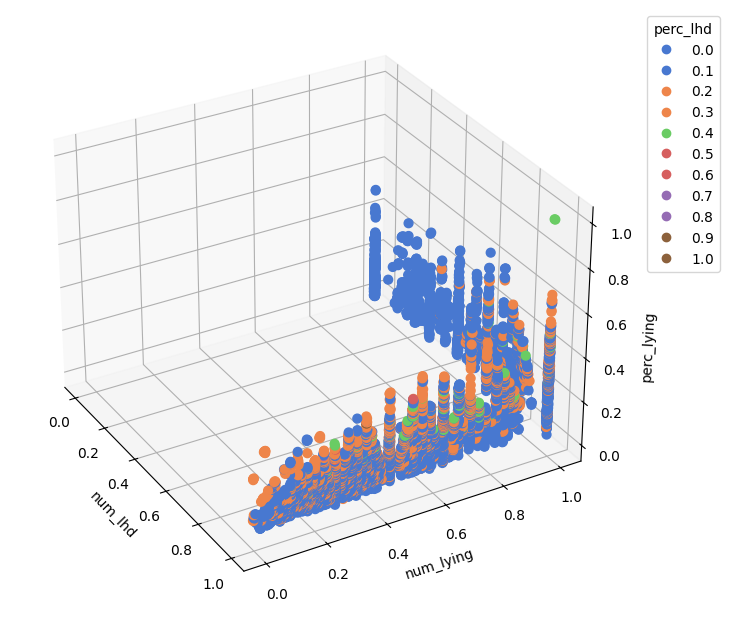

In [14]:
import re, seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

x = df.loc[:, df.columns[0]].to_numpy()
y = df.loc[:, df.columns[1]].to_numpy()
z = df.loc[:, df.columns[3]].to_numpy()
c = df.loc[:, df.columns[2]].to_numpy()

# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False, elev=30, azim=-30)
fig.add_axes(ax)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette('muted', 6).as_hex())

# plot
sc = ax.scatter(x, y, z, s=40, c=c, marker='o', cmap=cmap, alpha=1)
ax.set_xlabel(df.columns[0])
ax.set_ylabel(df.columns[1])
ax.set_zlabel(df.columns[3])

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2, title=df.columns[2])

# show
plt.show()

In [15]:
cluster_range = np.arange(2, config.GAP_STATISTIC_CLUSTER_RANGE)

In [16]:
from clustering import OptimalK_Wrapper as OptimalK_Wrapper_imported

In [17]:
X_mm = minmax(X)

In [18]:
optimal_K = OptimalK_Wrapper_imported(clusterer=agglomerative_clustering_function)
n_clusters = optimal_K.find_optimal_K(X_mm, cluster_array=cluster_range)
n_clusters

9

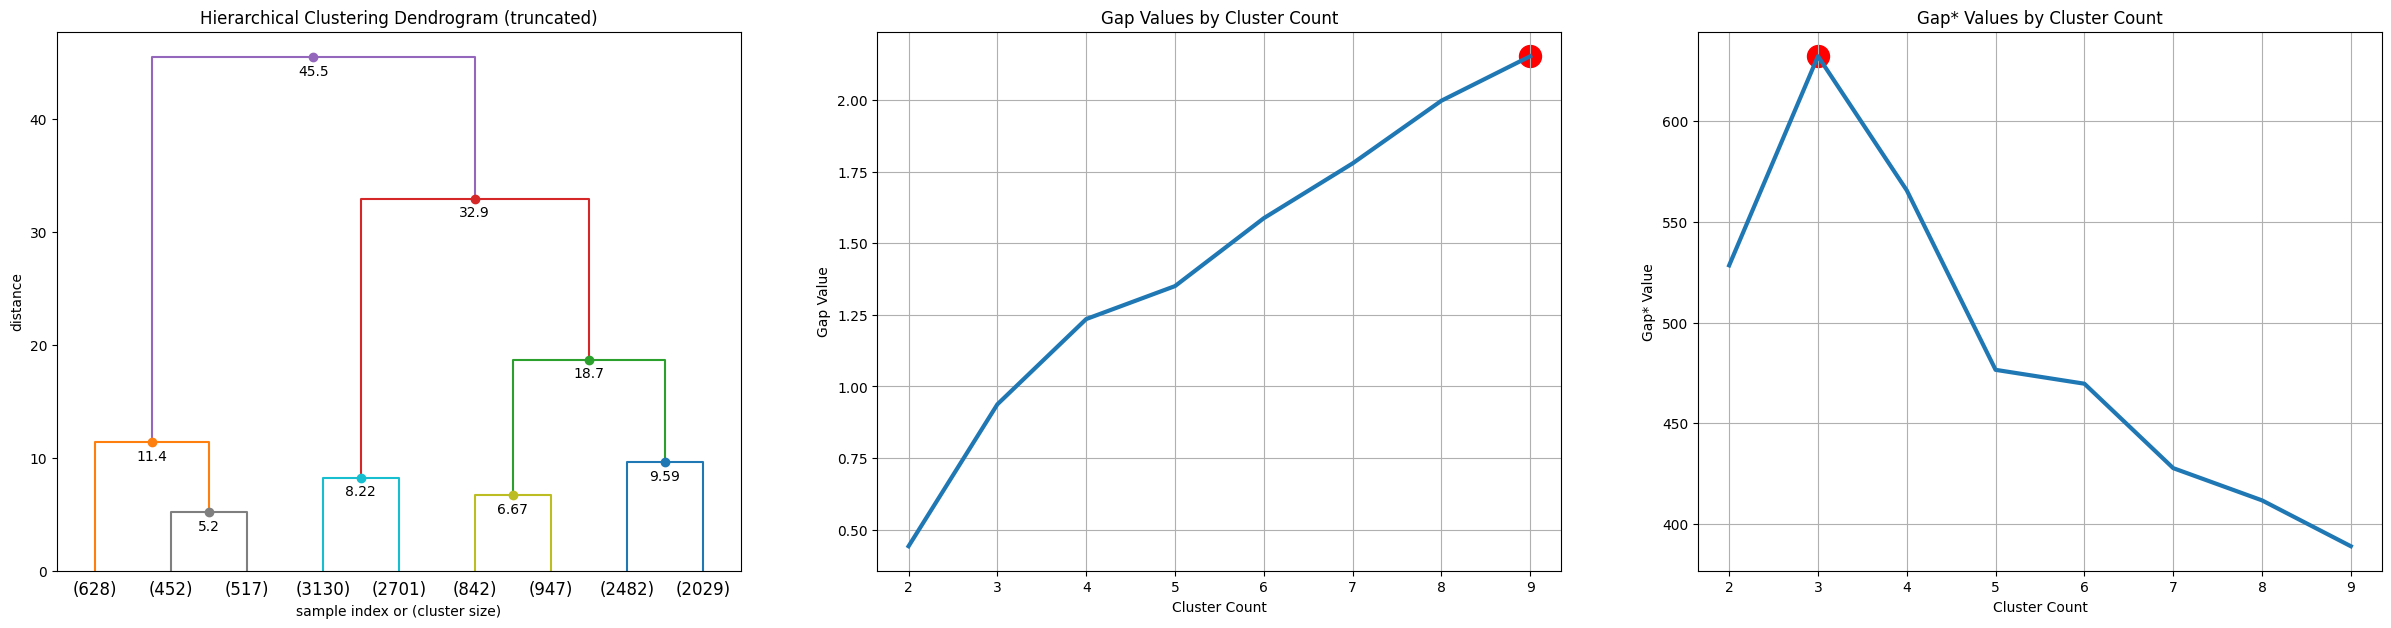

In [22]:
optimal_K.plot_gaps(AgglomerativeClustering, size = (30, 7))

In [18]:
cm = plt.get_cmap("gist_rainbow")
color_dict = {i: cm(1.0 * i / n_clusters) for i in range(n_clusters)}
link_color_func = lambda k: f'C{int(k)}'

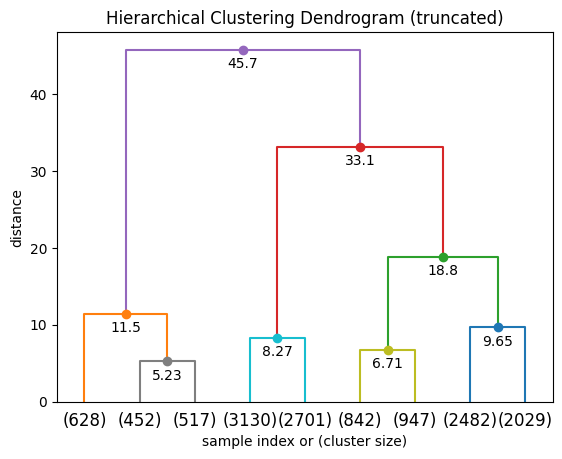

In [19]:
model = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward', compute_distances=True)
model.fit(X)

d = plot_dendrogram(model, dendogram_function=fancy_dendrogram, truncate_mode = 'lastp', p = n_clusters, link_color_func = link_color_func)

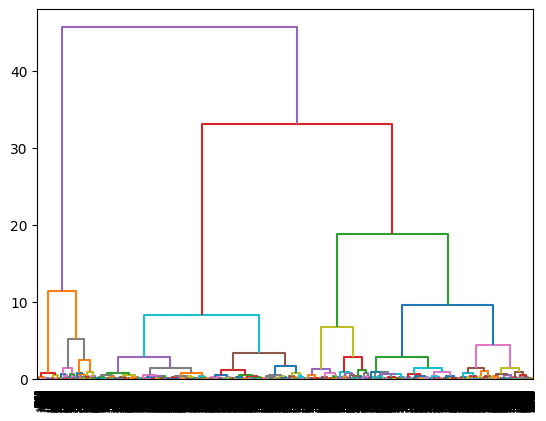

In [31]:
plot_dendrogram(model, dendogram_function=dendrogram, link_color_func = link_color_func)

In [122]:
df.head()

,num_lhd,num_lying,perc_lhd,perc_lying
0,0.997386,0.177832,0.235172,0.149147
1,0.999210,0.339877,0.288189,0.142687
2,0.996284,0.092859,0.140066,0.068714
3,0.996265,0.370205,0.162903,0.141116
4,0.996338,0.358147,0.181927,0.182173


In [129]:
cluster_centers, _ = agglomerative_clustering_function(X, 3)

In [130]:
cluster_centers

array([[0.96553869, 0.74801982, 0.00841783, 0.08357722],
       [0.25135107, 0.99999181, 0.00171253, 0.06281235],
       [0.99999159, 0.32495086, 0.00848329, 0.05021468]])

In [119]:
cluster_centers[:, 0]

array([0.91795278, 0.99681354, 0.13465885])

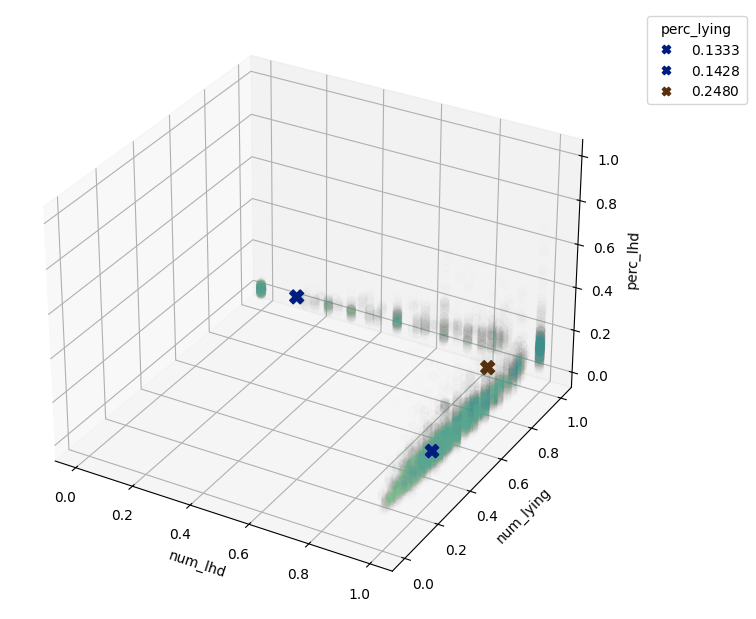

In [120]:
import re, seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

x = df.loc[:, df.columns[0]].to_numpy()
y = df.loc[:, df.columns[1]].to_numpy()
z = df.loc[:, df.columns[2]].to_numpy()
c = df.loc[:, df.columns[3]].to_numpy()

cluster_x = cluster_centers[:, 0]
cluster_y = cluster_centers[:, 1]
cluster_z = cluster_centers[:, 2]
cluster_c = cluster_centers[:, 3]

# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False, elev=30, azim=-60)
fig.add_axes(ax)



# get colormap from seaborn
cluster_cmap = ListedColormap(sns.color_palette('dark', 6).as_hex())
# plot
sce = ax.scatter3D(cluster_x, cluster_y, cluster_z, s=100, c=cluster_c, marker='X', cmap=cluster_cmap, alpha=1)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette('crest', 6).as_hex())
sc = ax.scatter3D(x, y, z, s=40, c=c, marker='o', cmap=cmap, alpha=0.004)
ax.set_xlabel(df.columns[0])
ax.set_ylabel(df.columns[1])
ax.set_zlabel(df.columns[2])

# legend
plt.legend(*sce.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2, title=df.columns[3])

# show
plt.show()